# Standardising Australia Hazard Maps

The goal of this notebook is to develop and provide examples of mapping climate hazards for Australia so that data can be consistently presented.
Examples will include maps for Australia and for selected states or regions.

In [1]:
import datetime
datetime.datetime.today().date()

datetime.date(2024, 6, 4)

In [2]:
import sys
print(sys.executable)

/g/data/hh5/public/./apps/cms_conda/envs/analysis3-24.04/bin/python


In [3]:
cd /g/data/mn51/users/gt3409/plotting_maps/

/g/data/mn51/users/gt3409/plotting_maps


In [4]:
# Plot Australian map without hazard

In [5]:
import xarray as xr

In [6]:
# import colormap packages
import matplotlib.cm as cm
import cmaps

In [7]:
# code adapted from https://stackoverflow.com/questions/75668431/plotting-points-on-australia-map-in-python

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import seaborn as sns

# Define the list of cities and their latitudes/longitudes
cities = ['Sydney', 'Melbourne', 'Brisbane', 'Perth', 'Adelaide', 'Canberra', 'Hobart', 'Darwin']
lats = [-33.865143, -37.813629, -27.469771, -31.953512, -34.928499,  -35.282001, -42.8821, -12.4637]
longs = [151.209900, 144.963165, 153.025124, 115.857048, 138.600739, 149.128998, 147.3272, 130.8444]


crs = 'epsg:7844'
xlim = (110,170)
ylim = (-45, -5)


# Create the DataFrame with the city data
data = {'cityname': cities,
        'lats': lats,
        'longs': longs,}
df = pd.DataFrame(data)
df.columns=['name', 'lat', 'lon']
df

,name,lat,lon
0,Sydney,-33.865143,151.209900
1,Melbourne,-37.813629,144.963165
2,Brisbane,-27.469771,153.025124
3,Perth,-31.953512,115.857048
4,Adelaide,-34.928499,138.600739
5,Canberra,-35.282001,149.128998
6,Hobart,-42.882100,147.327200
7,Darwin,-12.463700,130.844400


In [8]:
logo = image.imread("ACS_Logo_Blue_on_white_Stacked.png")

In [9]:
from matplotlib.colors import ListedColormap

In [10]:
# These are a dictionary of suggested colormaps
# see here: https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml

cmap_dict = {"drought_severity": cmaps.drought_severity,
             "temp1":cmaps.temp1,
             "posneg_2":cmaps.posneg_2,
             "hotcold_18lev":cmaps.hotcold_18lev,
             "RdYlGn_r":cm.RdYlGn_r,
             "hotres":cmaps.hotres,
             "balance":cmaps.cmocean_balance,
             "BuRd":cm.RdBu_r,
             "seismic":cm.seismic,
             "BlWhRe":cmaps.BlWhRe,
             "BlRe":cmaps.BlRe,
             "bwr":cm.bwr,
             "coolwarm":cmaps.MPL_coolwarm,
             "BrBG":cm.BrBG,
             "drywet":cmaps.CBR_drywet,
             "GMT_drywet": cmaps.GMT_drywet,
            "precip_diff_12lev":cmaps.precip_diff_12lev,
             "prcp_1":cmaps.prcp_1,
             "prcp_2":cmaps.prcp_2,
             "prcp_3":cmaps.prcp_3,
             "YlGnBu":cm.YlGnBu,
             "tempo":cmaps.cmocean_tempo,
             "wet":cmaps.CBR_wet,
             "BlueYellowRed":cmaps.BlueYellowRed,
             "RdYlGn":cm.RdYlGn,
             "Spectral":cm.Spectral,
             "YlOrRd":cm.YlOrRd,
             "hot_r": cm.hot_r,
             "hot": cm.hot,
             "AFDRS_category":ListedColormap(["white","green","orange", "red", "darkred"]),
             "rh_19lev": cmaps.rh_19lev,
             "sunshine_9lev":cmaps.sunshine_9lev,
             "sunshine_diff_12lev":cmaps.sunshine_diff_12lev,
             "inferno":cm.inferno,
             "Oranges":cm.Oranges,
             "OrRd":cm.OrRd,
             "Greens": cm.Greens,
             "RdPu": cm.RdPu,
             "dense": cmaps.cmocean_dense,
             "OceanLakeLandSnow":cmaps.OceanLakeLandSnow,
            }

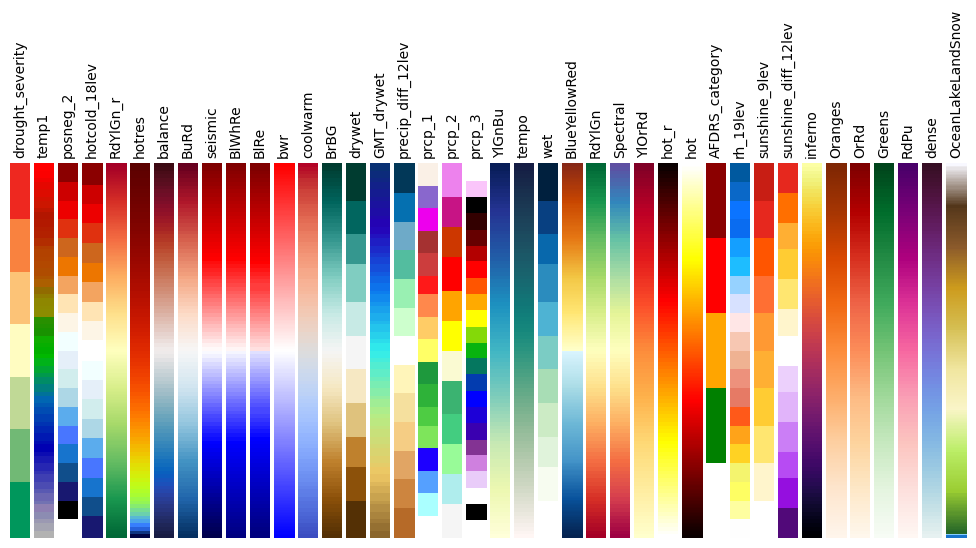

In [11]:
from pylab import *
from numpy import outer
rc('text', usetex=False)
a=outer(arange(0,1,0.01),ones(10))
figure(figsize=(10,5))
subplots_adjust(top=0.8,bottom=0.05,left=0.01,right=0.99)
maps=[m for m in cmap_dict]
l=len(maps)+1
for i, m in enumerate(maps):
    subplot(1,l,i+1)
    axis("off")
    imshow(a,aspect='auto',cmap=cmap_dict[m],origin="lower")
    title(m,rotation=90,fontsize=10)
savefig("colormaps.png",dpi=100,facecolor='gray')

In [12]:
# This dictionary gives some sugeestions on the scale of the colour map to use for some variables. The scales are taken from cliamte maps on bom.gov.au/cliamte
tick_dict = {"annual_pr":  [0, 50, 100, 200, 300, 400, 600, 1000, 1500, 2000, 3000, 6000],
             "6mon_pr":    [0, 50, 100, 200, 300, 400, 600,  900, 1200, 1800, 2400, 6000],
             "season_pr":  [0, 10,  25,  50, 100, 200, 300,  400,  600,  800, 1200, 2500],
             "month_pr" :  [0,  1,   5,  10,  25,  50, 100,  200,  300,  400,  600, 1200],
             "rain_days": [0, 2, 3, 5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175],
             "frost_days": [0, 10, 20, 30, 40, 50, 75, 100, 150, 300],
             "frost_days_mon":[0, 2, 5, 10, 15, 20, 25, 31],
             "temperature": np.arange(-9,49, 3),
             "temp_anom_day": np.arange(-14, 14.1, 2),
             "temp_anom_mon": np.arange(-7, 7.1, 1),
             "temp_anom_ann": np.arange(-3.5, 3.6, 0.5),
             "apparent_temp": np.arange(-6, 42, 3),
             "percent": np.arange(0,101,10),
             "rain_anom_mon": [-1000, -400, -200, -100, -50, -25, -10, 0, 10, 25, 50, 100, 200, 400, 1000],
             "rain_anom_3mon": [-2000, -600, -400, -200, -100, -50, -25, 0, 25, 50, 100, 200, 400, 600, 2000],
             "rain_anom_6mon": [-3000, -1200, -800, -400, -200, -100, -50, 0, 50, 100, 200, 400, 800, 1200, 3000],
             "rain_anom_ann": [-4000, -1800, -1200, -800, -400, -200, -100, 0, 100, 200, 400, 800, 1200, 1800, 4000],
             "rain_diff_mon": [-1000, -400, -200, -100, -50, -25, -10, 10, 25, 50, 100, 200, 400, 1000],
             "rain_diff_ann": [-3000, -1800, -1200, -800, -400, -200, -100, 100, 200, 400, 800, 1200, 1800, 3000],
            }            
             

In [13]:
from shapely.geometry import box

name = "australia"
australia = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')

# Define the CRS of the shapefile manually
australia.crs = crs

xlim = (110,170)
ylim = (-45, -5)

map_total_bounds = [xlim[0], ylim[0], xlim[1], ylim[1]]
# map_total_bounds = australia.total_bounds

not_australia = gpd.GeoSeries(data = [box(*box(*map_total_bounds).bounds).difference(australia["geometry"].values[0])],
                              crs=crs,)


In [14]:
def plot_aus_shapefiles(name =  "aus_states_territories",
                        data = None,
                        facecolor = None, 
                        edgecolor = "black",
                        figsize = (8,6),
                        title = None,
                        crs = 'epsg:7844',
                        area_linewidth = 0.3,
                        xlim = (110,170),
                        ylim = (-45, -10),
                        cmap = None,
                        varname = None,
                        cbar_extent = "both",
                        ticks = None, 
                        date_range = "",
                        mask_not_australia = True,
                        issued_date = datetime.datetime.today().date().strftime('%d/%m/%Y'),
                        dataset_name = None,
                        baseline = None,
                        label_states = False,
                        contourf = False,
                        select_area = None,
                       ):
    """This function takes a name of a Australian shapefile collection for data in /g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/ 
    and plots a map of Australia with the shape outlines. The map is saved as a png in your working directory.
    This function returns fig and ax.
    facecolor reccommendations include "white", "lightgrey", "none"
    edgecolor reccommendations include "black" and "white"
    """

    try:
        gdf = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')
    except:
        print(f"Could not read /g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp")
        
    # Define the CRS of the shapefile manually
    gdf.crs = crs

    # Set up the plot
    # sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=figsize)
    
    if data is not None:
        norm = mpl.colors.BoundaryNorm(ticks, cmap.N)
        # plot the hazard data
        if contourf:
            plt.contourf(data.lon, data.lat, data, cmap = cmap, norm=norm, levels=ticks)
        else:
            plt.pcolormesh(data.lon, data.lat, data, cmap = cmap, norm=norm)
        cbar = plt.colorbar(extend = cbar_extent, cax=ax.inset_axes([0.85,0.2, 0.03, 0.6]), ticks=ticks, norm=norm)
        cbar.ax.set_ylabel(varname)
        facecolor = "none"

    if mask_not_australia:
        # outside the shape, fill white
        not_australia.plot(ax=ax, facecolor="white", linewidth=0)
        # plot the shape edges, eg state borders

    if label_states and name=="aus_states_territories":
        # label the states with their name in the centre of the state
        states = ["WA", "NT", "SA", "QLD", "NSW", "VIC", "TAS"]
        lats = [-26.06, -19.7, -29.0, -24.2, -32.3, -37.1, -42.4]
        lons = [119.9, 133,  133, 143.6, 143.7, 142.0, 145.3]
        for lon, lat, state in zip(lons, lats, states):
            plt.text(lon, lat, state, size=12)
    
    gdf.plot(ax=ax,
             facecolor=facecolor,
             edgecolor=edgecolor, 
             linewidth=area_linewidth,
            )

    # if select a specific area
    if select_area is None:
        plt.xlim(xlim)
        plt.ylim(ylim)
    else:
        assert isinstance(select_area, list), "select_area must be a list"
        # select state
        area =gdf.loc[gdf.STE_NAME21.isin(select_area)] 
        map_total_bounds = area.total_bounds
        minx, miny, maxx, maxy = map_total_bounds
        buffer = 0.1*np.max([(maxy-miny), (maxx-minx)])
        
        not_area =  gpd.GeoSeries(data = [box(*box(*map_total_bounds).buffer(3*buffer).bounds).difference(area.dissolve()["geometry"].values[0])],
                                      crs=crs,)

        # outside the shape, fill white
        not_area.plot(ax=ax, facecolor="white", linewidth=0)
        # plot the shape edges, eg state borders
        
        plt.xlim(minx - buffer, maxx + 3*buffer)
        plt.ylim(miny - buffer, maxy + 1.5*buffer)      
        
    
    # Set the plot title and axis labels
    if title is None:
        title = name

    ax = plt.gca()
    ax.text(0.15,0.1,f"{title}\n{date_range}",
            horizontalalignment='left',
            transform=ax.transAxes)

    # Place logo in top left
    ax.imshow(logo, extent=(0.0, 0.3, 0.85, 1.0),  transform=ax.transAxes, zorder = 10) 
    # print base period inside bottom left corner
    ax.text(x=0.01, y=0.01, s= f"Base period: {baseline}", fontsize=6, transform=ax.transAxes)
    # print copyright outside bottom left corner
    ax.text(x=0.01, y=-0.03, s= f"(C) Commonwealth of Australia {datetime.datetime.now().year}, Australian Climate Service", fontsize=6, transform=ax.transAxes)
    # print data source inside bottom right
    ax.text(x=0.99, y=0.01, s= f"Dataset: {dataset_name}", fontsize=6, transform=ax.transAxes, horizontalalignment="right")
    ax.text(x=0.99, y=-0.03, s= f"Issued: {issued_date}", fontsize=6, transform=ax.transAxes, horizontalalignment="right")

    # remove any lat lon labels and ticks
    plt.xlabel('')
    plt.ylabel('')
    plt.tick_params(axis="both", which = "both", bottom =False, left=False, labelbottom = False, labelleft=False)
    
    plt.tight_layout()

    plt.savefig(f"{title}.png",)
    return fig, ax

In [15]:
shape_files = [ "aus_local_gov", "aus_states_territories", "australia", "nrm_regions", "river_regions"]

In [16]:
broadacre_file = '/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/broadacre_regions/aagis_asgs16v1_g5a.shp'


In [33]:
for name in shapegdf.columns

Index(['STE_NAME21', 'AREASQKM21', 'LOCI_URI21', 'geometry'], dtype='object')

In [17]:
name = "aus_local_gov"
gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')

,LGA_CODE22,LGA_NAME22,STE_CODE21,STE_NAME21,AREASQKM,LOCI_URI21,SHAPE_Leng,SHAPE_Area,geometry
0,10050,Albury,1,New South Wales,305.6386,https://linked.data.gov.au/dataset/asgsed3/LGA...,1.321768,0.030560,"POLYGON ((146.86566 -36.07292, 146.86512 -36.0..."
1,10180,Armidale,1,New South Wales,7809.4406,https://linked.data.gov.au/dataset/asgsed3/LGA...,6.034583,0.732825,"POLYGON ((152.38816 -30.52639, 152.38812 -30.5..."
2,10250,Ballina,1,New South Wales,484.9692,https://linked.data.gov.au/dataset/asgsed3/LGA...,1.511121,0.044843,"MULTIPOLYGON (((153.57106 -28.87381, 153.57106..."
3,10300,Balranald,1,New South Wales,21690.7493,https://linked.data.gov.au/dataset/asgsed3/LGA...,11.489912,2.115528,"POLYGON ((143.00433 -33.78164, 143.01538 -33.7..."
4,10470,Bathurst,1,New South Wales,3817.8645,https://linked.data.gov.au/dataset/asgsed3/LGA...,5.395114,0.370149,"POLYGON ((149.84877 -33.52784, 149.84864 -33.5..."
...,...,...,...,...,...,...,...,...,...
542,74660,West Arnhem,7,Northern Territory,49675.0342,https://linked.data.gov.au/dataset/asgsed3/LGA...,23.235319,4.130572,"MULTIPOLYGON (((132.99069 -11.07872, 132.99049..."
543,74680,West Daly,7,Northern Territory,14069.6980,https://linked.data.gov.au/dataset/asgsed3/LGA...,7.556529,1.178262,"MULTIPOLYGON (((129.69308 -14.80637, 129.69233..."
544,79399,Unincorporated NT,7,Northern Territory,19777.3595,https://linked.data.gov.au/dataset/asgsed3/LGA...,19.180110,1.648842,"MULTIPOLYGON (((130.74789 -12.42749, 130.74985..."
545,89399,Unincorporated ACT,8,Australian Capital Territory,2358.1330,https://linked.data.gov.au/dataset/asgsed3/LGA...,3.032133,0.234227,"POLYGON ((149.06239 -35.15910, 149.09134 -35.1..."


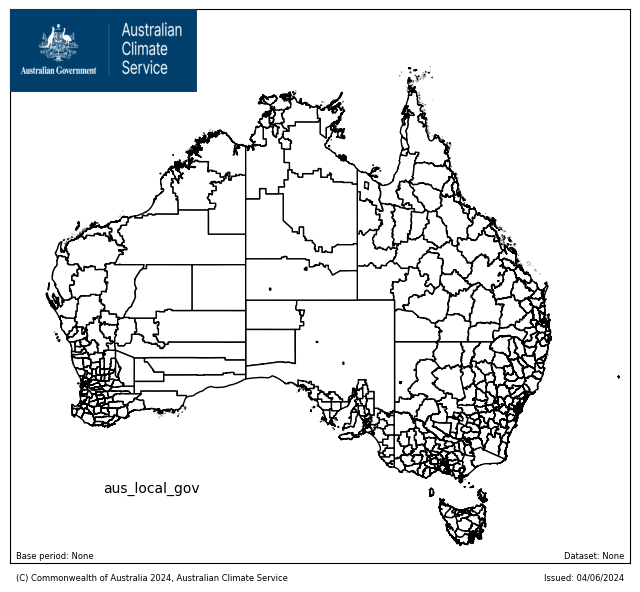

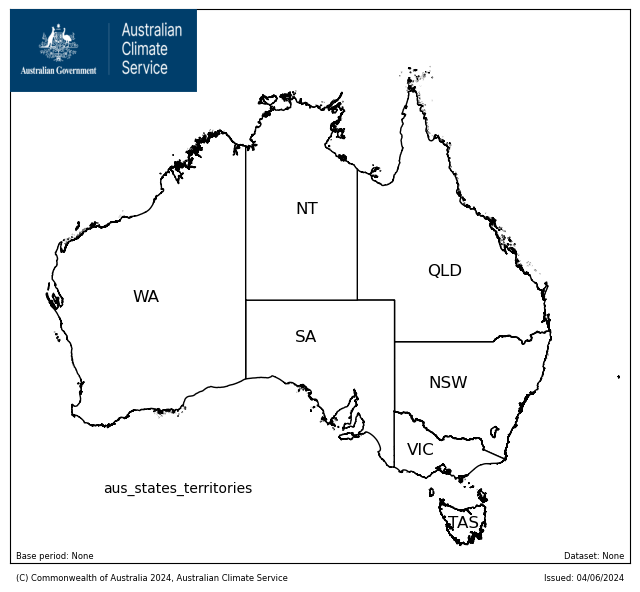

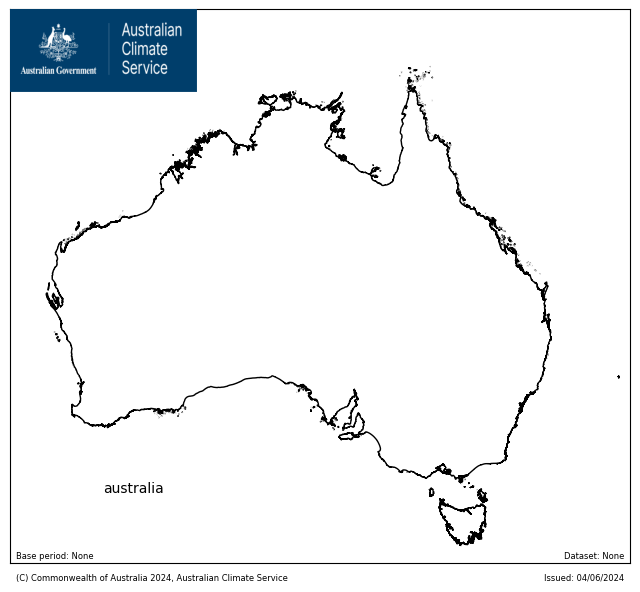

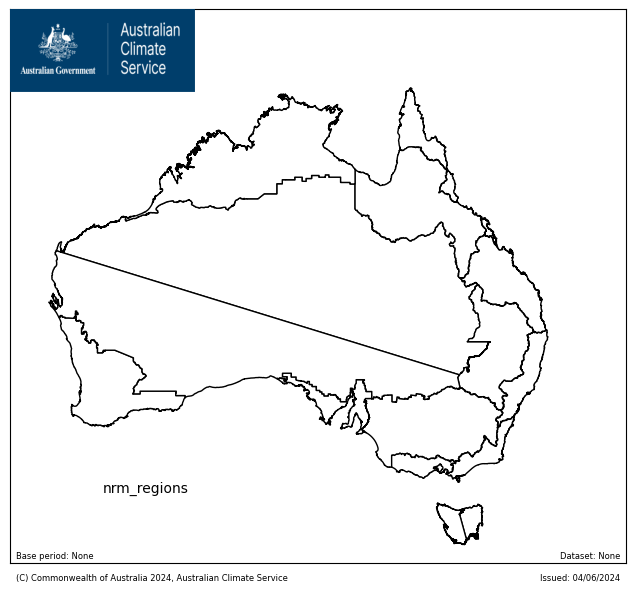

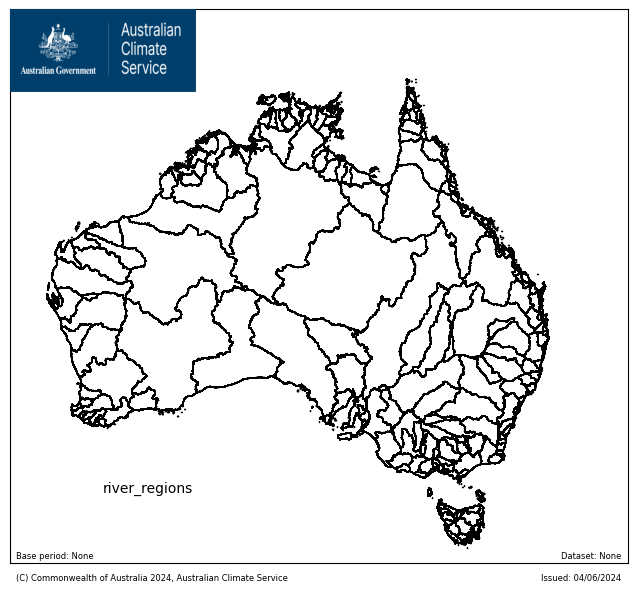

In [18]:
facecolor = "white" # "lightgrey", "none"
edgecolor = "black" # "white"
crs = 'epsg:7844'
area_linewidth = 1
xlim = (110,160)
ylim = (-45, -5)

for name in shape_files:
    plot_aus_shapefiles(name = name,
                        facecolor = facecolor, 
                        edgecolor = edgecolor,
                        title = None,
                        crs = crs,
                        area_linewidth = area_linewidth,
                        xlim = xlim,
                        ylim = ylim,
                        label_states = True);


In [19]:
# Plot Australian map

In [20]:
# Plot Australian map with states

In [21]:
# plot one state

In [22]:
# load some data
ds = xr.open_dataset("/g/data/lp01/CORDEX-CMIP6/CMIP6/DD/gr1.5/CSIRO/ACCESS-CM2/historical/r4i1p1f1/CCAM-v2203-SN/v1-r1/mon/tas/v20231206/tas_gr1.5_ACCESS-CM2_historical_r4i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1_mon_195101-201412.nc")
ds

<xarray.Dataset> Size: 8MB
Dimensions:  (time: 768, lon: 62, lat: 41)
Coordinates:
  * time     (time) datetime64[ns] 6kB 1951-01-15T12:00:00 ... 2014-12-15T12:...
  * lon      (lon) float64 496B 90.0 91.5 93.0 94.5 ... 177.0 178.5 180.0 181.5
  * lat      (lat) float64 328B -51.75 -50.25 -48.75 -47.25 ... 5.25 6.75 8.25
Data variables:
    tas      (time, lat, lon) float32 8MB ...
Attributes: (12/32)
    CDI:                       Climate Data Interface version 2.2.1 (https://...
    Conventions:               CF-1.10
    source:                    Conformal Cubic Atmospheric Model v2203
    institution:               Commonwealth Scientific and Industrial Researc...
    axiom_version:             0.2.0
    axiom_schema:              CORDEX
    ...                        ...
    tracking_id:               0fba49e2-43d5-4afc-afee-47ff1aee832d
    variable_id:               tas
    doi:                       https://doi.org/10.25914/rd73-4m38
    history:                   Fri Feb 16 21:44:02 2024: cdo -O -s -L -P 28 -...
    CDO:                       Climate Data Operators version 2.2.0 (https://...
    cdo_openmp_thread_number:  28

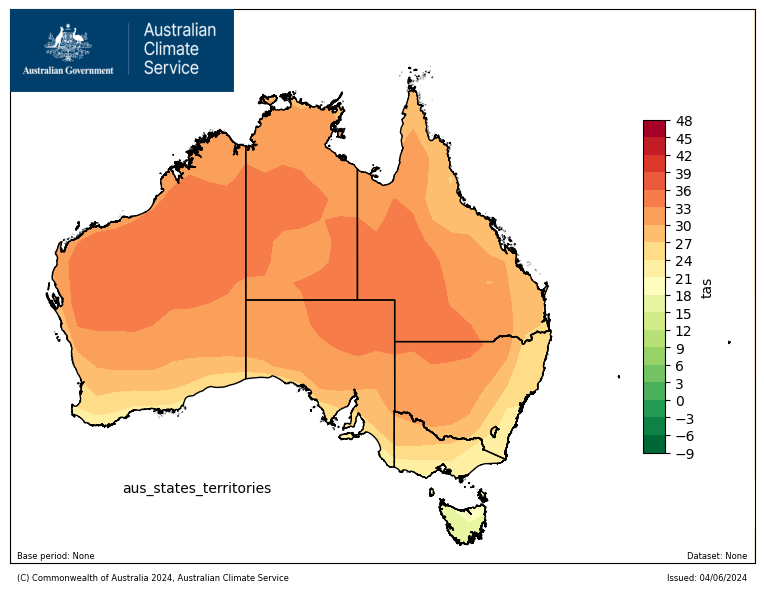

In [23]:
facecolor = "white" # "lightgrey", "none"
edgecolor = "black" # "white"
name =  "aus_states_territories"
crs = 'epsg:7844'
area_linewidth = 1
xlim = (110,170)
ylim = (-45, -5)
data = ds.tas.max(dim="time")-273.15
cmap = cmap_dict["RdYlGn_r"]
varname = "tas"
cbar_extent="both"
ticks = np.arange(-9,49, 3)


plot_aus_shapefiles(name = name,
                    data = data,
                    facecolor = facecolor, 
                    edgecolor = edgecolor,
                    title = None,
                    crs = crs,
                    area_linewidth = area_linewidth,
                    xlim = xlim,
                    ylim = ylim,
                    cmap = cmap,
                    cbar_extent = cbar_extent,
                    varname = varname,
                    ticks=ticks,
                   contourf=True);

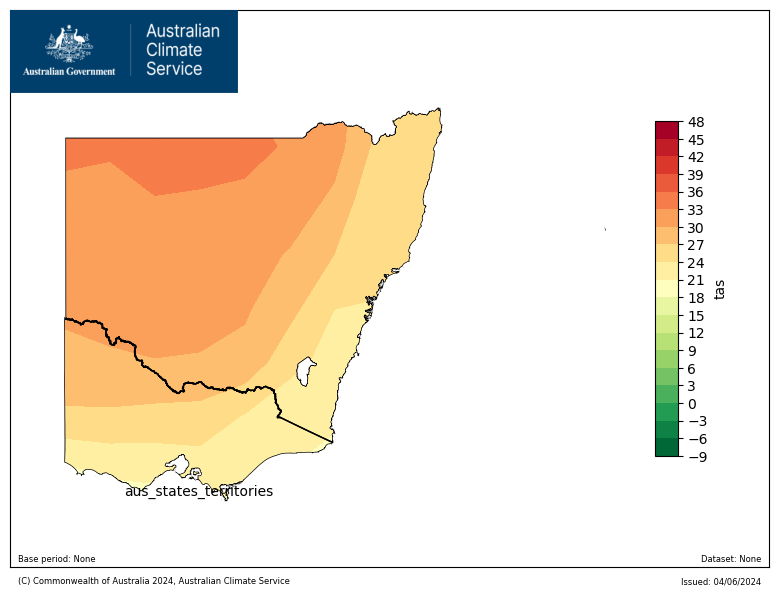

In [25]:
plot_aus_shapefiles(name = name,
                    data = data,
                    facecolor = facecolor, 
                    edgecolor = edgecolor,
                    title = None,
                    crs = crs,
                    area_linewidth = area_linewidth,
                    xlim = xlim,
                    ylim = ylim,
                    cmap = cmap,
                    cbar_extent = cbar_extent,
                    varname = varname,
                    ticks=ticks,
                   contourf=True,
                   select_area=["New South Wales", "Victoria"]);

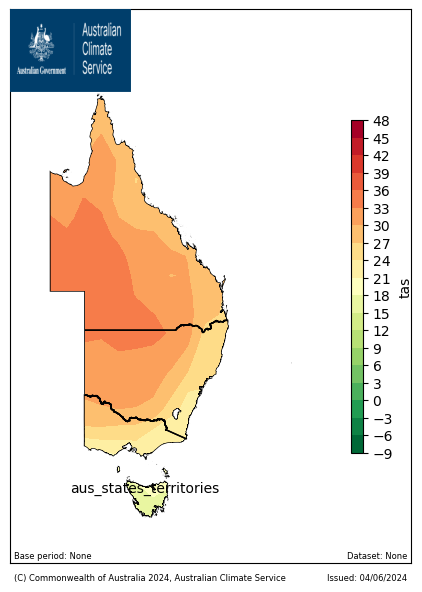

In [28]:
plot_aus_shapefiles(name = name,
                    data = data,
                    facecolor = facecolor, 
                    edgecolor = edgecolor,
                    title = None,
                    crs = crs,
                    area_linewidth = area_linewidth,
                    xlim = xlim,
                    ylim = ylim,
                    cmap = cmap,
                    cbar_extent = cbar_extent,
                    varname = varname,
                    ticks=ticks,
                   contourf=True,
                   select_area=["New South Wales", "Victoria", "Tasmania", "Queensland"]);

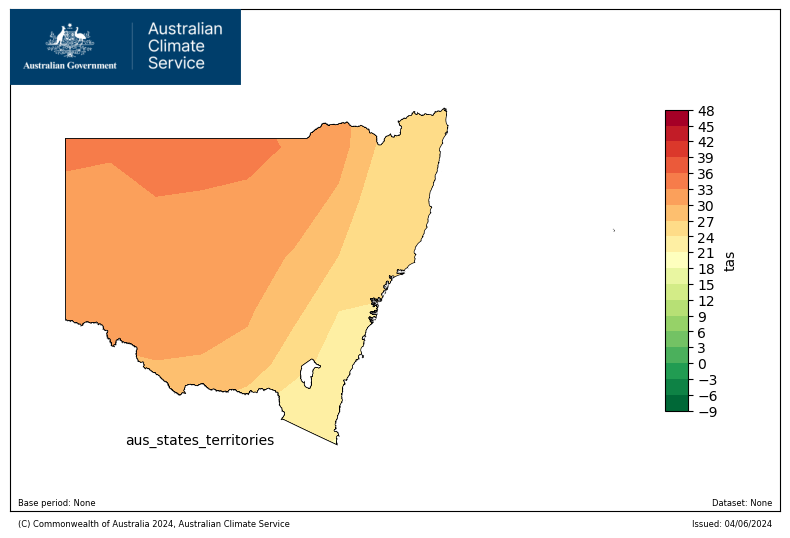

In [26]:
facecolor = "white" # "lightgrey", "none"
edgecolor = "black" # "white"
name =  "aus_states_territories"
crs = 'epsg:7844'
area_linewidth = 1
xlim = (110,170)
ylim = (-45, -5)
data = ds.tas.max(dim="time")-273.15
cmap = cmap_dict["RdYlGn_r"]
varname = "tas"
cbar_extent="both"
ticks = np.arange(-9,49, 3)


plot_aus_shapefiles(name = name,
                    data = data,
                    facecolor = facecolor, 
                    edgecolor = edgecolor,
                    title = None,
                    crs = crs,
                    area_linewidth = area_linewidth,
                    xlim = xlim,
                    ylim = ylim,
                    cmap = cmap,
                    cbar_extent = cbar_extent,
                    varname = varname,
                    ticks=ticks,
                   contourf=True,
                   select_area=["New South Wales"]);

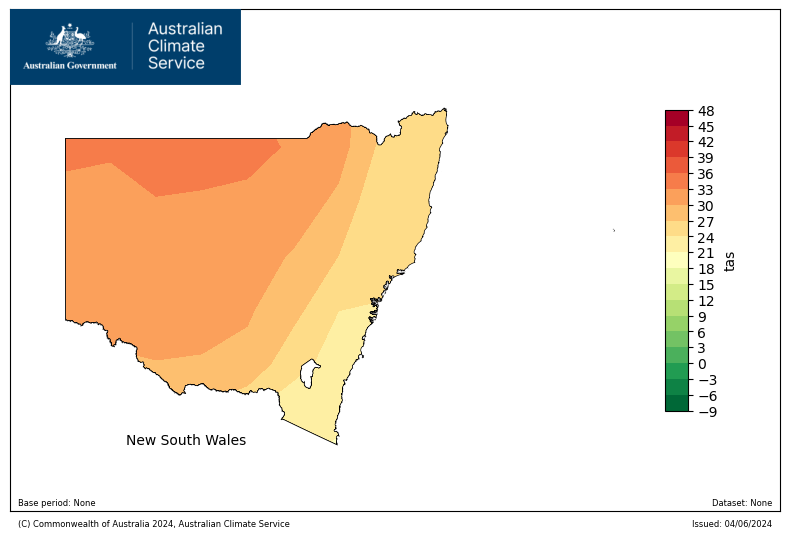

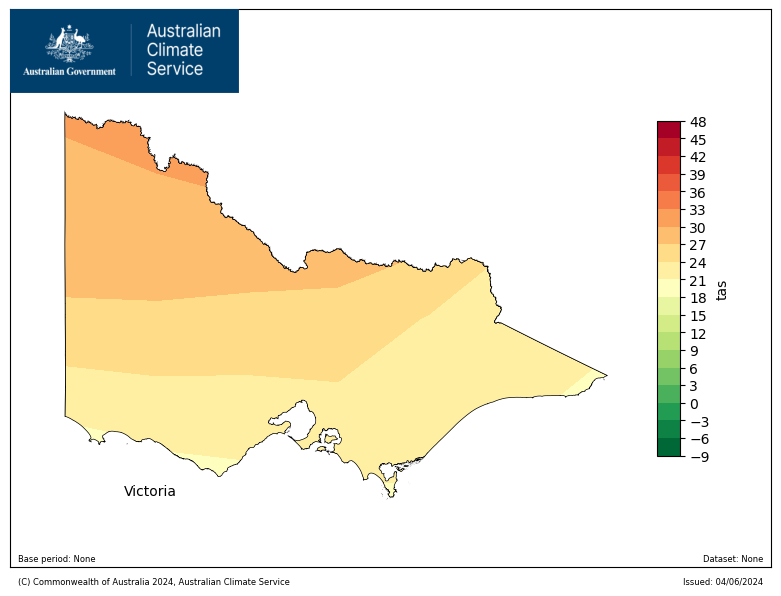

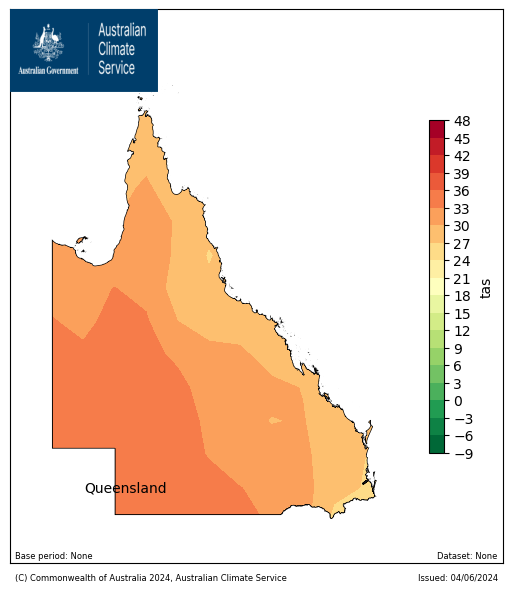

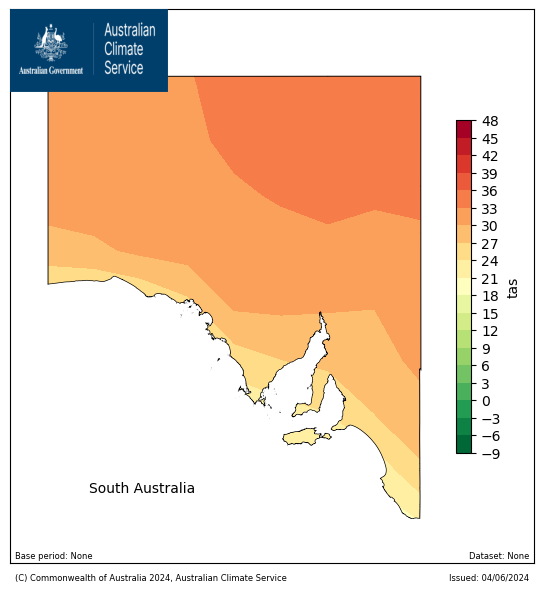

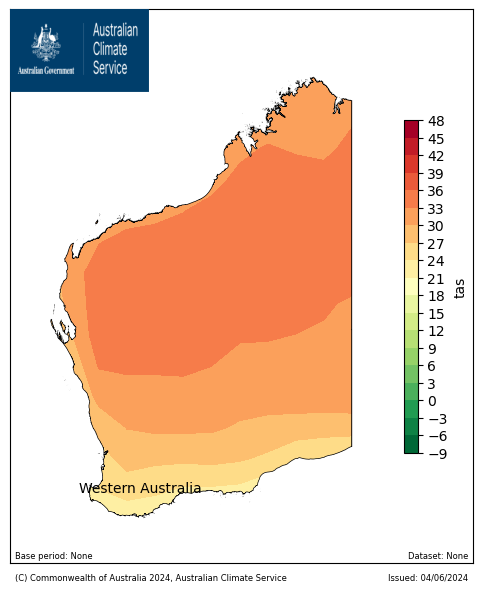

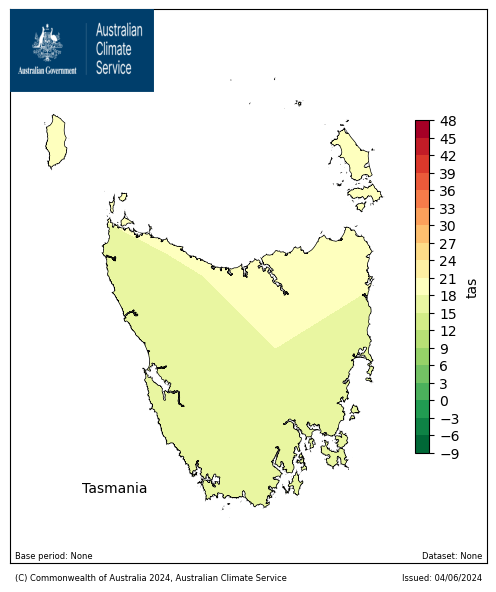

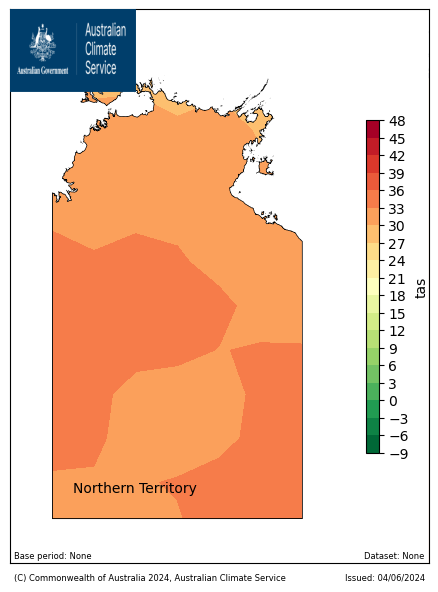

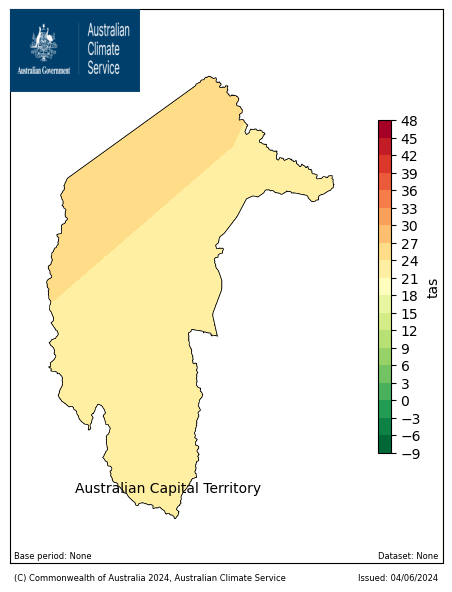

In [27]:
name = "aus_states_territories" 
gdf = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')

for state in list(gdf.STE_NAME21)[:-1]:
    plot_aus_shapefiles(name = name,
                    data = data,
                    facecolor = facecolor, 
                    edgecolor = edgecolor,
                    title = state,
                    crs = crs,
                    area_linewidth = area_linewidth,
                    xlim = xlim,
                    ylim = ylim,
                    cmap = cmap,
                    cbar_extent = cbar_extent,
                    varname = varname,
                    ticks=ticks,
                   contourf=True,
                   select_area=[state]);

To do:
- test with different data
- fix shape of plots
- fix shape of logo 
- nealty present examples
- select multiple areas (not states)
